In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from WindPy import w
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

## 获取起始日期

In [3]:
today = datetime.datetime.today()

In [4]:
today.strftime('%Y-%m-%d')

'2019-02-25'

In [5]:
start_date = today - datetime.timedelta(365) # 最近1年

In [6]:
start_date.strftime('%Y-%m-%d')

'2018-02-25'

## 获取数据

In [7]:
df = pd.read_excel(u'../data/资产与宏观数据.xlsx')

In [8]:
df

,Variables,Name,Assets
0,M0001385,M2同比,000300.SH
1,M0001383,M1同比,000905.SH
2,M0000545,工业增加值同比,881001.WI
3,M5525763,社融同比,CBA00602.CS
4,M0017128,PMI新订单,CBA02002.CS
5,M0000605,进出口同比,AU9999.SGE
6,M0001428,社消同比,HSI.HI


In [9]:
var2name = {k: v for k, v in zip(df['Variables'], df['Name'])}

In [10]:
data = w.wsd(df['Assets'].tolist()[:7], 'close', start_date, today)

In [11]:
price = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)
price.index = pd.to_datetime(price.index)

In [12]:
price.tail()

,000300.SH,000905.SH,881001.WI,CBA00602.CS,CBA02002.CS,AU9999.SGE,HSI.HI
2019-02-19,3439.6078,4667.2836,3667.6786,118.7323,80.0985,290.67,28228.13
2019-02-20,3451.9273,4667.6243,3677.8153,118.7381,80.1186,292.33,28514.05
2019-02-21,3442.7056,4659.1431,3668.3837,118.7031,80.1213,290.71,28629.92
2019-02-22,3520.1182,4777.2977,3751.6944,118.7450,80.1055,288.91,28816.30
2019-02-25,3520.1182,4777.2977,3751.6944,118.7450,80.1055,288.91,28816.30


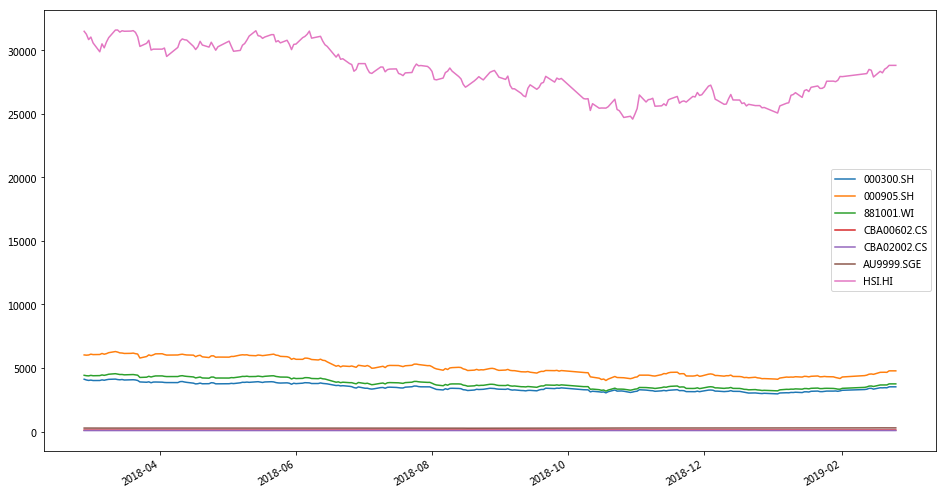

In [13]:
price.plot(figsize=(16, 9))

In [14]:
macro_variables = [x for x in df['Variables'] if str(x).find('.') == -1 and str(x) != 'nan']

In [15]:
macro_variables

[u'M0001385',
 u'M0001383',
 u'M0000545',
 u'M5525763',
 u'M0017128',
 u'M0000605',
 u'M0001428']

In [16]:
data = w.edb(macro_variables, start_date, today)

In [17]:
macro_df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[var2name[x] for x in macro_variables])

In [18]:
macro_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
2018-02-28,8.8,8.5,-2.119883,12.653160,51.0,24.3,9.700000
2018-03-31,8.2,7.1,6.000000,11.917040,53.3,5.3,10.100000
2018-04-30,8.3,7.2,7.000000,11.886410,52.9,16.5,9.400000
2018-05-31,8.3,6.0,6.800000,11.591320,53.8,18.2,8.500000
2018-06-30,8.0,6.6,6.000000,11.101210,53.2,12.1,9.000000
2018-07-31,8.5,5.1,6.000000,10.840980,52.3,18.3,8.800000
2018-08-31,8.2,3.9,6.100000,10.802550,52.2,14.5,9.000000
2018-09-30,8.3,4.0,5.800000,10.575280,52.0,14.1,9.200000
2018-10-31,8.0,2.7,5.900000,10.224710,50.8,17.0,8.600000
2018-11-30,8.0,1.5,5.400000,9.873883,50.4,3.4,8.100000


In [19]:
macro_nav = (1+macro_df.pct_change()).cumprod()
macro_nav.iloc[0] = 1

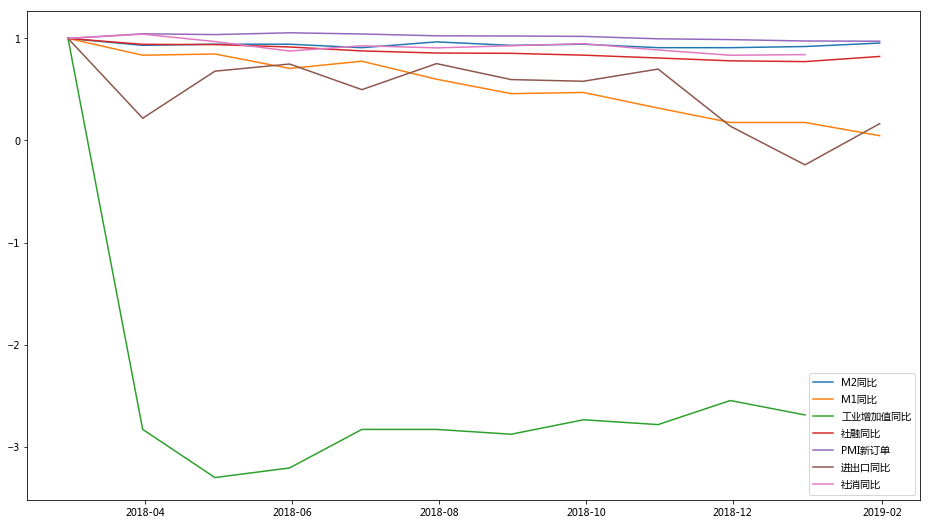

In [20]:
macro_nav.plot(figsize=(16, 9))

In [21]:
macro_df.to_excel('../data/macro_nav.xlsx')

In [22]:
ret_df = pd.DataFrame()

In [23]:
ret_df[u'成长股'] = price['000905.SH'].pct_change()
ret_df[u'价值股'] = price['000300.SH'].pct_change()
ret_df[u'港股'] = price['HSI.HI'].pct_change()
ret_df[u'黄金'] = price['AU9999.SGE'].pct_change()
ret_df[u'国债'] = price['CBA00602.CS'].pct_change()
ret_df[u'信用债'] = price['CBA02002.CS'].pct_change()

## 生成EWMA相关性矩阵

In [24]:
cor_df = pd.DataFrame(index= ret_df.columns, columns=macro_df.columns.tolist())

In [25]:
for asset in cor_df.index:
    for var in cor_df.columns:
        if var in macro_df.columns:
            s, t = (1+ret_df[asset]).cumprod().resample('M').last(), (1+macro_df[var].pct_change()).cumprod()
            corr = s.ewm(alpha=0.02, ignore_na=True, adjust=True).corr(t)
            cor_df.loc[asset, var] = corr[-1]

In [26]:
cor_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
成长股,0.283626,0.941891,-0.722839,0.95643,0.915516,0.458428,0.73458
价值股,0.369206,0.903436,-0.703596,0.964289,0.907044,0.510792,0.733676
港股,0.507348,0.783564,-0.724752,0.920879,0.808232,0.410217,0.630485
黄金,-0.0319951,-0.723509,0.313137,-0.514728,-0.806339,-0.741698,-0.565109
国债,-0.0158702,-0.829102,0.495521,-0.729734,-0.864246,-0.637514,-0.84849
信用债,0.0476756,-0.902431,0.496451,-0.709238,-0.943959,-0.603776,-0.649843


In [27]:
cor_df.to_excel('../data/macro_ewma_cor.xlsx')

In [28]:
trend = {}
for var in cor_df.columns:
    if var in macro_df.columns:
        t = macro_df[var]
    ret = t.pct_change()
    up, down = ret[ret > 0].sum(), -ret[ret < 0].sum()
    smooth = 1e-2
    if up > down:
        trend[var] = (up + smooth) / (down + smooth)
    else:
        trend[var] = -(down + smooth) / (up + smooth)

In [29]:
for k, v in trend.iteritems():
    print k, v

PMI新订单 -1.3613650311328187
M2同比 -1.268650836534802
工业增加值同比 -15.482979399893297
社融同比 -3.4856874302948455
进出口同比 -2.227291156109427
M1同比 -15.406304658783014
社消同比 -1.9728933596016855


In [30]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [31]:
board = pd.DataFrame(index=cor_df.index, columns=cor_df.columns)
for var in cor_df.columns:
#     print var
    x = cor_df[var] * trend[var]
    board[var] = sigmoid(x.astype(np.float32))

In [32]:
trend_df = pd.DataFrame(trend, index=[u'变量趋势'])

In [33]:
board = trend_df.append(board)

In [34]:
board = board[cor_df.columns]

In [35]:
board

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
变量趋势,-1.268651,-1.540630e+01,-15.482979,-3.485687,-1.361365,-2.227291,-1.972893
成长股,0.411003,4.988021e-07,0.999986,0.034429,0.223332,0.264822,0.190117
价值股,0.384997,9.020420e-07,0.999981,0.033530,0.225339,0.242746,0.190392
港股,0.344423,5.718342e-06,0.999987,0.038795,0.249684,0.286249,0.223761
黄金,0.510146,9.999856e-01,0.007781,0.857439,0.749833,0.839158,0.753042
国债,0.505033,9.999971e-01,0.000465,0.927144,0.764328,0.805327,0.842106
信用债,0.484884,9.999990e-01,0.000459,0.922169,0.783312,0.793276,0.782802


In [36]:
board.to_excel('../data/macro_dashboard.xlsx')